In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [13]:
from pylab import *

import aesara
import aesara.tensor as at
import arviz as az
import pandas as pd
import pymc as pm
import seaborn as sns
import warnings
import xarray as xr

sns.set_context('notebook')
sns.set_palette('husl')

The model here is that we have some set of observations of a multi-dimensional quantity $\mathbf{x}$ and we want to understand its population.  If we had a specific, physically-motivated model for the population we might fit that (for a description of how this works, see [Mandel, Farr, & Gair (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.486.1086M/abstract), [Farr, et al. (2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...741..103F/abstract), [Vitale, et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020arXiv200705579V/abstract), [Miller, Callister, & Farr (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...895..128M/abstract)); but often we only have a phenomenological interest in the population.  In that case, we might choose to fit a multivariate Gaussian to the population ([Isi, Chatziioannou, & Farr (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123l1101I/abstract)) as a way of extracting the population mean and variance (note that such fitting will *also* have the effect of stabilizing or "shrinking" our estimates of the observations in each system ([Miller, Callister, & Farr (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...895..128M/abstract); [Lieu, et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.468.4872L/abstract); [Feeney, Wandelt, & Ness (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.3258F/abstract), [Sutter, et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014MNRAS.438..768S/abstract))).

Our combined posterior for the true parameters $\mathbf{x}_i$ and the population mean $\mathbf{\mu}$ and variance $\mathbf{\Sigma}$ given noisy observations of each object $\mathbf{x}_{\mathrm{obs}}$ is 
$$
p\left( \left\{ \mathbf{x}_i \right\}, \mathbf{\mu}, \mathbf{\Sigma} \mid \left\{ \mathbf{x}_{i,\mathrm{obs}} \right\} \right) \propto p\left( \mathbf{\mu}, \mathbf{\Sigma} \right) \prod_{i} p\left( \mathbf{x}_\mathrm{i,obs} \mid \mathbf{x}_i \right) N\left( \mathbf{x}_i \mid \mathbf{\mu}, \mathbf{\Sigma} \right)
$$
where $p\left( \mathbf{x}_{\mathrm{obs}} \mid \mathbf{x} \right)$ is the likelihood for observing $\mathbf{x}_{\mathrm{obs}}$ given that the true quantity is $\mathbf{x}$, $N$ is the multivariate normal density, and $p\left( \mathbf{\mu}, \mathbf{\Sigma} \right)$ is a prior on the population-level parameters $\mathbf{\mu}$ and $\mathbf{\Sigma}$.

If we are not interested in the event-level parameters, but only want to measure the population, then we can integrate $\mathbf{x}$ out of the posterior and obtain the marginal posterior for $\mathbf{\mu}$ and $\mathbf{\Sigma}$ (this is, generally, a good idea if you can implement it well, because you can always get *back* samples from the event-level posteriors using the methods described in [Miller, Callister, & Farr (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...895..128M/abstract)):
$$
p\left(\mathbf{\mu}, \mathbf{\Sigma} \mid \left\{ \mathbf{x}_{i,\mathrm{obs}} \right\} \right) \propto p\left( \mathbf{\mu}, \mathbf{\Sigma} \right) \prod_{i} \int \mathrm{d} \mathbf{x}_i \, p\left( \mathbf{x}_\mathrm{i,obs} \mid \mathbf{x}_i \right) N\left( \mathbf{x}_i \mid \mathbf{\mu}, \mathbf{\Sigma} \right)
$$

One way to implement the marginalization is to use samples to perform Monte-Carlo integration.  Let $\mathbf{x}_{ij}$ be $M_i$ samples from a posterior for the $i$th observation that used a prior density $p_i\left( \mathbf{x} \right)$.  Then we can approximate the integral as an average over samples: 
$$
p\left(\mathbf{\mu}, \mathbf{\Sigma} \mid \left\{ \mathbf{x}_{i,\mathrm{obs}} \right\} \right) \propto p\left( \mathbf{\mu}, \mathbf{\Sigma} \right) \prod_{i} \frac{1}{M_i} \sum_j \frac{N\left( \mathbf{x}_{ij} \mid \mathbf{\mu}, \mathbf{\Sigma} \right)}{p_i\left( \mathbf{x}_{ij} \right)}
$$
This approximation will be stable as long as 
1. The priors $p_i$ are broader than the populations supported by the posterior, so that the denominator never becomes dramatically smaller than the numerator (if it does, then the average can diverge even though the integral may be fully convergent).
1. The samples from each event are sufficiently dense that the population is not artificially broadened by the inter-sample spacing (this will eventually become problematic if, for example, the population model is used as a null test ([Isi, Chatziioannou, & Farr (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123l1101I/abstract)) and the null is an infinitely narrow population; eventually the number of samples required to adequately explore the narrow population will diverge, and the computational cost will become prohibitive).

The code below implements this idea in `pymc`.  Note that we impose fixed, unit-scale priors on the population level parameters $\mathbf{\mu}$ and $\mathbf{\Sigma}$, so if your problem is not unit-scale, you should transform your defenition of $\mathbf{x}$ or implement different priors.  We parameterize the covariance matrix using a vector of scales in each dimension and a correlation matrix with an LKJ prior; see [the Stan User Guide](https://mc-stan.org/docs/2_29/stan-users-guide/multivariate-hierarchical-priors.html#hyperpriors) for more discussion of this prior choice.

In [33]:
def make_monte_carlo_model(x_samples):
    nobs, nsamp, ndim = x_samples.shape
    with pm.Model() as model:
        mu = pm.Normal('mu', mu=0, sigma=1, shape=(ndim,))
        # The covariance matrix will be stored 'Sigma', the correlation matrix in 'Sigma_corr', and the marginal s.d. in 'Sigma_stds'
        Sigma_chol, _, _ = pm.LKJCholeskyCov('Sigma', eta=2, n=ndim, sd_dist=pm.HalfNormal.dist(sigma=1), compute_corr=True, store_in_trace=True)

        x_pop_dist = pm.MvNormal.dist(mu=mu, chol=Sigma_chol)

        # Apparently MvNormal won't work on 3D tensors, so we do some reshape magic
        x_logp = pm.logp(x_pop_dist, x_samples.reshape((-1, ndim))).reshape((nobs, nsamp))
        
        # Convince yourself that this formula gives the log of the product of the sum of the density evaluated at the samples.
        _ = pm.Potential('marginal_likelihood', pm.math.sum(pm.math.logsumexp(x_logp, axis=1)))

    return model

Let's try it out.  We will generate 2D observations from a delta-function population, draw samples from them, and then fit:

In [5]:
def draw_x_samples(Ndim, Nobs, Nsamp):
    Ndim = 2
    Nobs = 10
    Nsamp = 100
    x_true = zeros(Ndim)
    x_samples = []
    for _ in range(Nobs):
        # Make a random positive-definite covariance matrix:
        C = randn(Ndim, Ndim)
        C = np.dot(C, C.T)

        # Draw the observation
        x_obs = np.random.multivariate_normal(mean=x_true, cov=C)

        # Now the posterior is a Gaussian about x_obs
        xsamp = np.random.multivariate_normal(mean=x_obs, cov=C, size=Nsamp)
        x_samples.append(xsamp)
    x_samples = array(x_samples)
    return x_samples
Ndim = 2
Nobs = 10
Nsamp = 100
x_samples = draw_x_samples(Ndim, Nobs, Nsamp)

Make a cute plot of the posterior in a few of the observations:

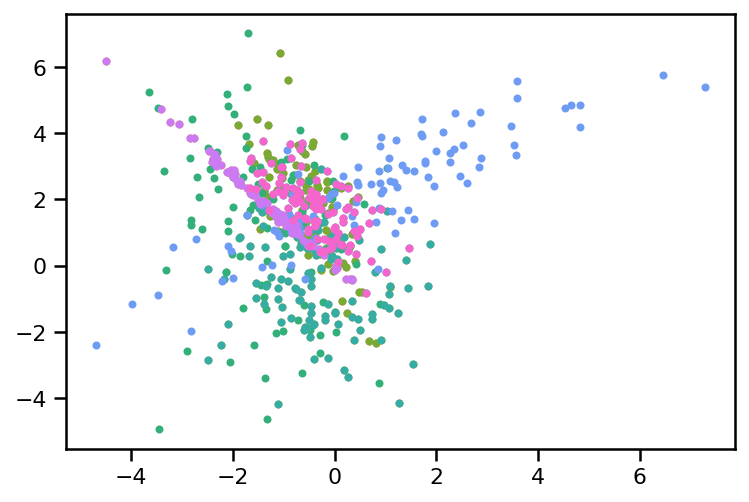

In [6]:
Nplot = 10
with sns.color_palette('husl', n_colors=Nplot):
    for _ in range(Nplot):
        i = randint(Nobs)
        plot(x_samples[i,:,0], x_samples[i,:,1], '.')


In [41]:
with make_monte_carlo_model(x_samples) as mc_model:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore') # Aesara throws a lot of unnecessary warnings here
        trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, Sigma]


/Users/wfarr/miniconda3/envs/HierShrinkagenD/lib/python3.10/site-packages/aesara/compile/function/types.py:964: RuntimeWarning: invalid value encountered in accumulate
  self.fn()
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 159 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.701, but should be close to 0.8. Try to increase the number of tuning steps.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [43]:
with mc_model:
    print(az.summary(trace, var_names=['mu', 'Sigma', 'Sigma_stds']))

                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0]          0.203  0.322  -0.481    0.753      0.017    0.012     373.0   
mu[1]          0.037  0.306  -0.535    0.620      0.011    0.009     741.0   
Sigma[0]       0.544  0.294   0.073    1.034      0.015    0.011     288.0   
Sigma[1]       0.022  0.276  -0.557    0.558      0.016    0.016     436.0   
Sigma[2]       0.493  0.282   0.079    0.996      0.014    0.010     289.0   
Sigma_stds[0]  0.544  0.294   0.073    1.034      0.015    0.011     288.0   
Sigma_stds[1]  0.554  0.305   0.121    1.110      0.017    0.012     267.0   

               ess_tail  r_hat  
mu[0]             387.0   1.00  
mu[1]             738.0   1.00  
Sigma[0]          135.0   1.01  
Sigma[1]          166.0   1.01  
Sigma[2]          121.0   1.00  
Sigma_stds[0]     135.0   1.01  
Sigma_stds[1]     160.0   1.00  


Ultimately, we find that the means and covariance components are consistent with zero, but the sampling is very poor, with lots of divergences occuring when the standard deviation becomes small.  This is the problem mentioned above, where the lower limit on the s.d. is set by the posterior sample spacing---you need to have at least one sample from each event within some number of s.d.s of the inferred mean or else the sampling will fail.  As you get larger and larger catalogs, this becomes impossible because the true posterior on the s.d. becomes more and more concentrated around zero.

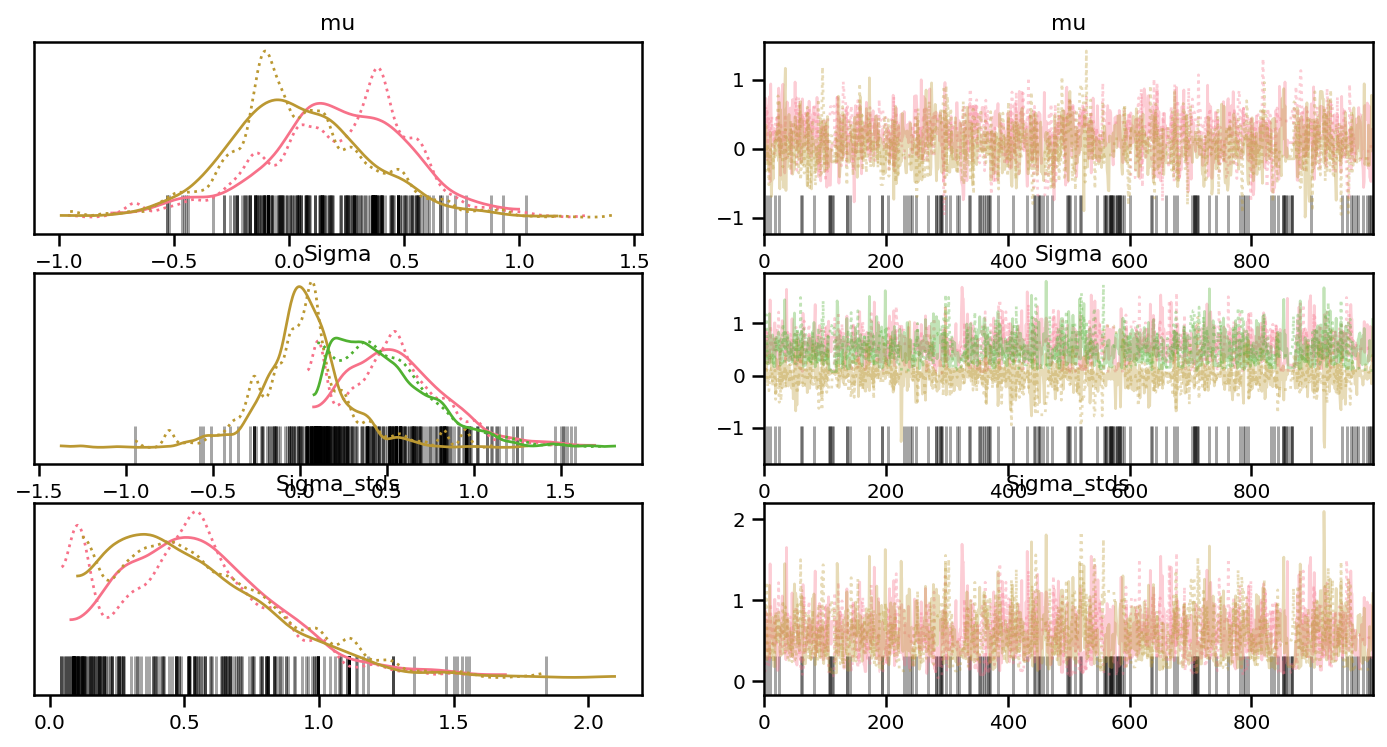

In [44]:
with mc_model:
    az.plot_trace(trace, var_names=['mu', 'Sigma', 'Sigma_stds'])

The solution to this problem is to produce an estimate of the likelihood for each event that is smooth, and can be evaluated at arbitrary locations.  Using a KDE over the samples we have been given is one such estimate; for Gaussian populations like this one, it has the added benefit that we can *analytically* perform the integral!  If the likelihood is represented as a KDE over $M$ samples $\mathbf{x}_j$ with bandwidth $\mathbf{\Sigma}_\mathrm{obs}$, then we have 
$$
\int \mathrm{d} \mathbf{x} \, p\left( \mathbf{x}_\mathrm{obs} \mid \mathbf{x} \right) N\left( \mathbf{x} \mid \mathbf{\mu}, \mathbf{\Sigma} \right) = \frac{1}{M} \sum_j N\left( \mathbf{x}_j \mid \mathbf{\mu}, \mathbf{\Sigma} + \mathbf{\Sigma}_\mathrm{obs} \right)
$$

See, for example, [Hogg, Price-Whelan, & Leistedt (2020)](https://arxiv.org/abs/2005.14199).

The implementation of the KDE in `pymc` is a bit tricky, because we can't use a plain `MvNormal` as we did above; the covariance matrix is event-specific, so we need a loop.  We accomplish this via the `map` function for looping in `aesara`.  

Note that we also play some tricks with `coordinates` and `dims` arguments to indicate the meaning of the various dimensions of our data and parameters (which are stored in the output chains).

In [30]:
def make_kde_model(x_samples):
    nobs, nsamp, ndim = x_samples.shape

    means = np.mean(x_samples, axis=1)
    deviations = x_samples - means[:,newaxis,:]
    dev_matrix = deviations[:,:,:,newaxis]*deviations[:,:,newaxis,:]
    covariances = np.mean(dev_matrix, axis=1)
    bws = covariances / nsamp**(2/(4+ndim)) # Scott's rule for the KDE bandwidth

    coordinates = {
        'observations': range(nobs),
        'samples': range(nsamp),
        'parameters': range(ndim),
        'parameters2': range(ndim) # For matrices, need a unique name
    }

    def event_marginal_loglike(xs, bw, mu, Sigma):
        Sigma_tot = bw + Sigma
        dist = pm.MvNormal.dist(mu=mu, cov=Sigma_tot)
        logp = pm.logp(dist, xs)
        return pm.logsumexp(logp)

    with pm.Model(coords=coordinates) as model:
        x_samples = pm.ConstantData('x_samples', x_samples, dims=("observations", "samples", "parameters"))
        bws = pm.ConstantData('bws', bws, dims=('observations', 'parameters', 'parameters2'))

        mu = pm.Normal('mu', mu=0, sigma=1, dims="parameters")
        # The covariance matrix will be stored 'Sigma', the correlation matrix in 'Sigma_corr', and the marginal s.d. in 'Sigma_stds'
        Sigma_chol, _, _ = pm.LKJCholeskyCov('Sigma', eta=2, n=ndim, sd_dist=pm.HalfNormal.dist(sigma=1), compute_corr=True, store_in_trace=True)

        Sigma = pm.Deterministic('Sigma_matrix', np.dot(Sigma_chol, Sigma_chol.T), dims=("parameters", "parameters2"))

        # Note: map returns *two* arguments, for some reason; the second is a dictionary of updates (side effects?) to tensor variables from the function
        event_marg_loglikes, _ = aesara.map(event_marginal_loglike, 
                                           sequences=[x_samples, bws],
                                           non_sequences=[mu, Sigma])

        # Convince yourself that this formula gives the log of the product of the sum of the density evaluated at the samples.
        _ = pm.Potential('marginal_likelihood', at.sum(event_marg_loglikes))

    return model

Once sampling is completed, we can draw from the inferred population of $\mathbf{x}$ values; the following code performs this:

In [ ]:
def generate_x_pop(trace):
    xs = []
    post = trace.posterior

    Nc, Nd, Np = post.mu.shape

    for c in post.chain:
        for d in post.draw:
            m = post.mu[c,d,:]
            L = zeros((Np,Np))
            L[tril_indices(Np)] = post.Sigma[c,d,:]

            xs.append(m + np.dot(L, randn(Np)))
    post["x_pop"] = xr.DataArray(array(xs).reshape(Nc, Nd, Np), dims=('chain', 'draw', 'parameters'))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, Sigma]


/Users/wfarr/miniconda3/envs/HierShrinkagenD/lib/python3.10/site-packages/aesara/compile/function/types.py:964: RuntimeWarning: invalid value encountered in accumulate
  self.fn()
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 538 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0]         -0.151  0.184  -0.506    0.206      0.006    0.005     891.0   
mu[1]          0.424  0.374  -0.278    1.105      0.013    0.010     838.0   
Sigma_stds[0]  0.216  0.192   0.000    0.558      0.006    0.004    1016.0   
Sigma_stds[1]  0.739  0.416   0.104    1.457      0.019    0.014     372.0   
x_pop[0]      -0.162  0.343  -0.913    0.401      0.009    0.006    1495.0   
x_pop[1]       0.431  0.916  -1.338    2.195      0.021    0.016    1893.0   

               ess_tail  r_hat  
mu[0]             690.0   1.01  
mu[1]             878.0   1.00  
Sigma_stds[0]     912.0   1.00  
Sigma_stds[1]     210.0   1.00  
x_pop[0]         1306.0   1.00  
x_pop[1]         1749.0   1.00  


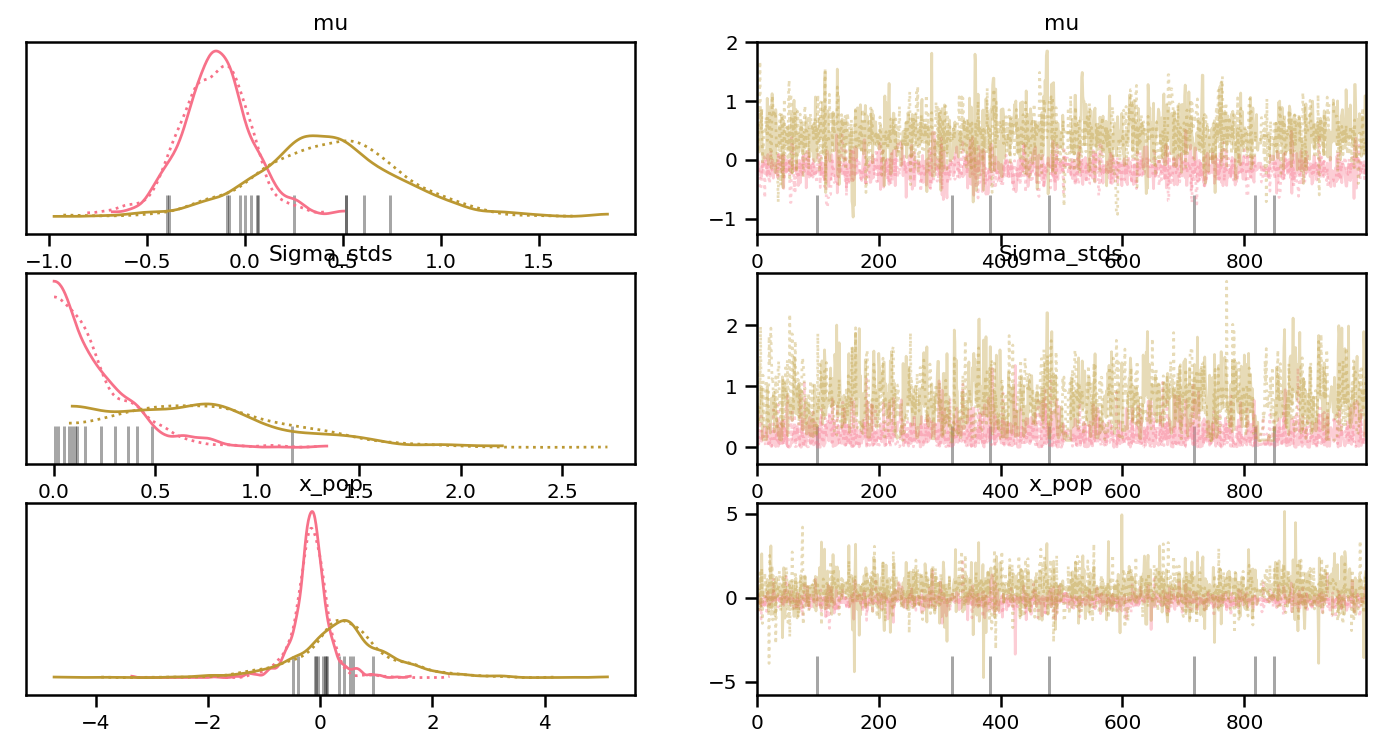

In [33]:
with make_kde_model(x_samples) as kde_model:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore') # Aesara throws a lot of unnecessary warnings here
        trace = pm.sample(init='jitter+adapt_full')
    generate_x_pop(trace)
    print(pm.summary(trace, var_names=['mu', 'Sigma_stds', 'x_pop']))
    az.plot_trace(trace, var_names=['mu', 'Sigma_stds', 'x_pop'], compact=True)

The sampling is still kinda shitty, but you can at least see that things are converging at the right place.  Let's do more events:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, Sigma]


/Users/wfarr/miniconda3/envs/HierShrinkagenD/lib/python3.10/site-packages/aesara/compile/function/types.py:964: RuntimeWarning: invalid value encountered in accumulate
  self.fn()
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 810 seconds.
The acceptance probability does not match the target. It is 0.7011, but should be close to 0.8. Try to increase the number of tuning steps.
We recommend running at least 4 chains for robust computation of convergence diagnostics


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0]          0.064  0.163  -0.242    0.393      0.007    0.006     538.0   
mu[1]         -0.053  0.155  -0.316    0.242      0.006    0.005     709.0   
Sigma_stds[0]  0.196  0.171   0.003    0.508      0.007    0.005     577.0   
Sigma_stds[1]  0.243  0.204   0.017    0.624      0.010    0.007     184.0   
x_pop[0]       0.072  0.307  -0.491    0.657      0.009    0.006    1163.0   
x_pop[1]      -0.052  0.336  -0.722    0.606      0.008    0.007    1503.0   

               ess_tail  r_hat  
mu[0]             268.0   1.00  
mu[1]             838.0   1.01  
Sigma_stds[0]     558.0   1.01  
Sigma_stds[1]      56.0   1.01  
x_pop[0]          923.0   1.00  
x_pop[1]         1495.0   1.00  


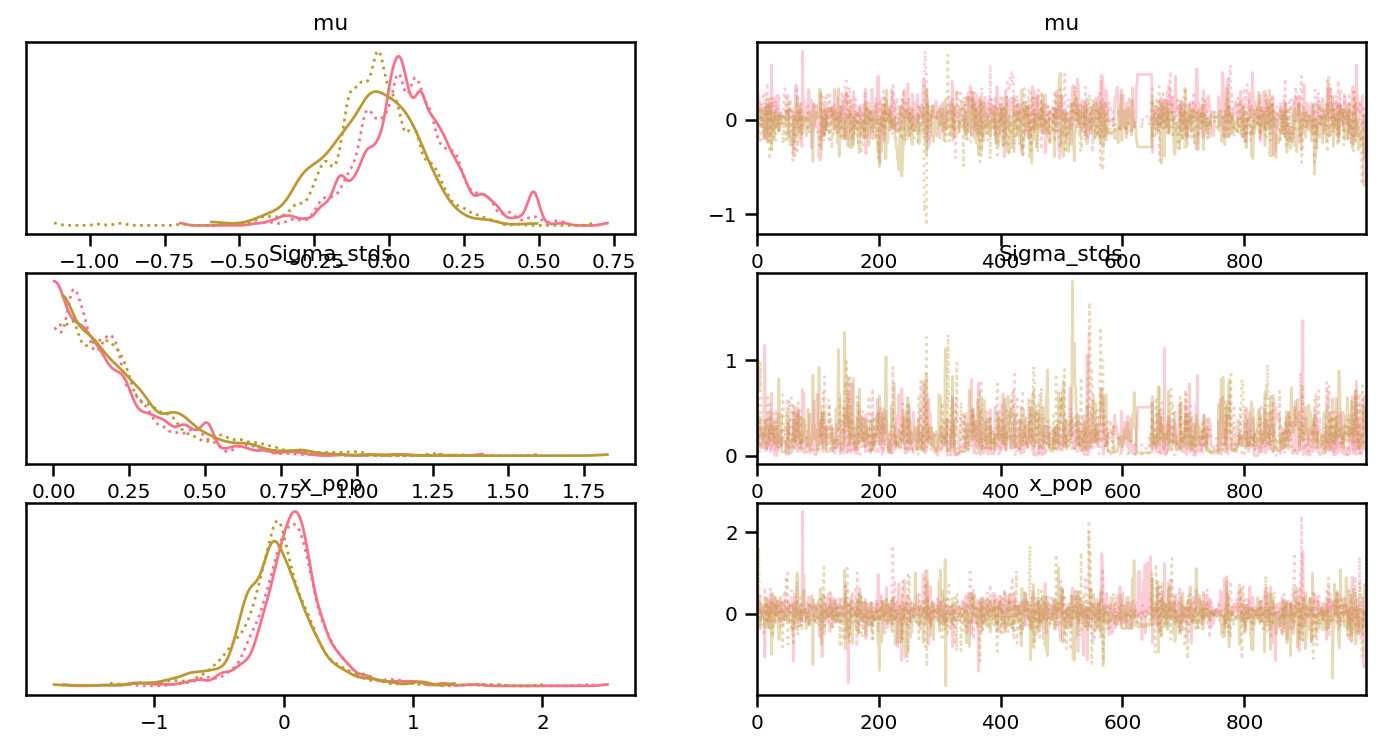

In [34]:
x_samples_large = draw_x_samples(Ndim, 10*Nobs, Nsamp)
with make_kde_model(x_samples_large) as model_kde_large:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        trace_large = pm.sample(init='jitter+adapt_full')
    generate_x_pop(trace_large)
    print(az.summary(trace_large, var_names=['mu', 'Sigma_stds', 'x_pop']))
    az.plot_trace(trace_large, var_names=['mu', 'Sigma_stds', 'x_pop'], compact=True)

We can plot the distribution of the inferred population; note that we have constrained it around the origin to a width of $\pm 0.2$ in each dimension, which is on the same order of magnitude as $1/\sqrt{N}$, as expected for $N = 100$ individual measurements with unit scale uncertainty.

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='x_pop\n0', ylabel='x_pop\n1'>,
        <AxesSubplot:>]], dtype=object)

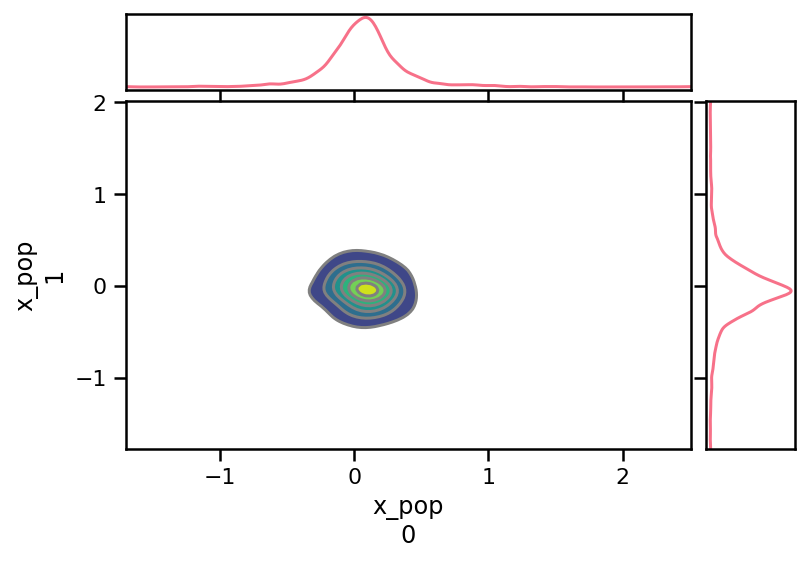

In [37]:
az.plot_pair(trace_large, var_names=['x_pop'], kind='kde', marginals=True)